In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
Seeds = { 
          10 : [512, 166, 538, 894, 449, 195, 88, 144, 903, 577, 830, 827, 537, 179, 660, 844, 999, 858, 744, 740, 221, 443, 219, 484, 5, 23, 465, 864, 245, 523],
          30 : [449, 144, 830, 179, 999, 740, 219, 23, 245, 588, 746, 967, 275, 389, 561, 775, 250, 121, 152, 696, 691, 836, 51, 371, 881, 594, 362, 511, 416, 372],
          50 : [903, 179, 744, 484, 245, 11, 450, 389, 167, 947, 152, 862, 283, 371, 431, 439, 416, 112, 613, 184, 46, 499, 890, 587, 217, 942, 808, 633, 174, 404],
          100 : [744, 245, 450, 167, 152, 283, 431, 416, 613, 46, 890, 217, 808, 174, 727, 615, 347, 455, 423, 846, 629, 729, 48, 806, 401, 859, 3, 67, 351, 232]
        }

class AlgorithmComparisonData():
    def __init__(self, wins, significant_wins, defeats, significant_defeats):
        self.wins = wins
        self.significant_wins = significant_wins
        self.defeats = defeats
        self.significant_defeats = significant_defeats

    def __str__(self):
        return f"wins: {self.wins}({self.significant_wins})\ndefeats: {self.defeats}({self.significant_defeats})"

class ExperimentsDataAnalyzer():

    def __init__(self):
        self.data_lake = {}

    def load_data(self, data_source_name, data_source_path):
        df = pd.read_csv(data_source_path, sep=';')
        self.data_lake[data_source_name] = df

    def get_data_frame(self, data_source_name):
        return self.data_lake[data_source_name].copy()

    def compare(self, ref_alg_datasource_name, target_alg_datasource_name):
        ref_df = self.get_data_frame(ref_alg_datasource_name)
        tgt_df = self.get_data_frame(target_alg_datasource_name)
        
        wins, swins = 0, 0 
        defeats, sdefeats = 0, 0
    
        for i in range(len(tgt_df)):
            data1 = ref_df.iloc[i][1:]
            data2 = tgt_df.iloc[i][1:]
            
            d1_mean = np.mean(data1)
            d2_mean = np.mean(data2) 
        
            is_signif = False
            if d1_mean == 0.0 and d2_mean == 0.0:
                is_signif = False
            else:
                stat, p = wilcoxon(data1, data2, zero_method="zsplit", )
                if p <= 0.05:
                    is_signif = True
            
            if d1_mean > d2_mean:
                wins += 1
                if is_signif:
                    swins += 1
        
            elif d1_mean < d2_mean:
                defeats += 1
                if is_signif:
                    sdefeats += 1

        return AlgorithmComparisonData(wins, swins, defeats, defeats)

    def clean_data(self):
        del self.data_lake
        self.data_lake = {}


In [3]:
analyzer = ExperimentsDataAnalyzer()
D=10

def load_data(analyzer, algorithm, function, D=10): 
    seed = Seeds[D][function-1]

    BASE_PATH = "~/Code/FIM-CGRASP/results/generations/"
    if algorithm == "dmlshade":
        config = "--dmlshade --crossgen --insert --er 0.2 --gs 50 --sf --no_archive  --analysis "
        BASE_PATH += f"DM_LSHADE/{config}/D{D}/cec-f{function}/s{seed}/"
    else:
        BASE_PATH += f"LSHADE/D{D}/cec-f{function}/s{seed}/"
        
    analyzer.load_data(f"pop-costs-{algorithm}-f{function}-d{D}", BASE_PATH + "pop-costs.csv")
    pop_costs_df = analyzer.get_data_frame(f"pop-costs-{algorithm}-f{function}-d{D}")
    gens_count = len(pop_costs_df)
    print(gens_count)
    pop_generations = {}
    for i in range(gens_count-1):
        analyzer.load_data(f"pop-{algorithm}-f{function}-d{D}-g{i+1}", BASE_PATH + "population/" + f"g{i+1}.csv")
        analyzer.load_data(f"elite-{algorithm}-f{function}-d{D}-g{i+1}", BASE_PATH + "elite/" + f"g{i+1}.csv")
    print(f"f{function} finished")

In [21]:
import random

THRESHOLD = 10000
# Cost evolution for all individuals:
def plot_cost_evolution(func_number, algorithm="dmlshade", D=10):
    pop_costs_df = analyzer.get_data_frame(f"pop-costs-{algorithm}-f{func_number}-d{D}")
    filtered = pop_costs_df[pop_costs_df != -1]
    filtered = filtered[filtered < THRESHOLD]
    filtered.plot(legend=False)

def plot_scatter_cost_evolution(func_number, algorithm="dmlshade", D=10):
    pop_costs_df = analyzer.get_data_frame(f"pop-costs-{algorithm}-f{func_number}-d{D}")
    filtered = pop_costs_df[pop_costs_df != -1]
    filtered = filtered[filtered < THRESHOLD]
    for col in filtered.columns:
        if random.random() < 1: 
            plt.scatter(x=filtered[col].index, y=filtered[col], marker='+', c='c')
    
    if algorithm == "dmlshade":
        gens_count=len(pop_costs_df)
        for dmg in range(70, gens_count, 70): 
            plt.axvline(x = dmg, color = 'b')

    plt.title(algorithm.upper())

def plot_cost_statistics(func_number, algorithm="dmlshade", D=10):
    pop_costs_df = analyzer.get_data_frame(f"pop-costs-{algorithm}-f{func_number}-d{D}")
    gens_count=len(pop_costs_df)
    filtered = pop_costs_df[pop_costs_df != -1]
    filtered = filtered[filtered < THRESHOLD]

    mean_costs = filtered.mean(axis=1).plot()
    median_costs = filtered.median(axis=1).plot()
    min_costs = filtered.min(axis=1).plot()
    max_costs = filtered.max(axis=1).plot()

    if algorithm == "dmlshade":
        for dmg in range(70, gens_count, 70): 
            plt.axvline(x = dmg, color = 'b')

def get_stat(func_number, algorithm, statistic, D=10):
    pop_costs_df = analyzer.get_data_frame(f"pop-costs-{algorithm}-f{func_number}-d{D}")
    filtered = pop_costs_df[pop_costs_df != -1]
    filtered = filtered[filtered < THRESHOLD]
    
    if statistic == 'min':
        return filtered.min(axis=1)

    if statistic == 'max':
        return filtered.max(axis=1)

    if statistic == 'mean':
        return filtered.mean(axis=1)

    if statistic == 'median':
        return filtered.median(axis=1)

In [12]:
analyzer.clean_data()
function=11
dimension=10
load_data(analyzer, "lshade", function, dimension)
load_data(analyzer, "dmlshade", function, dimension)

2163
f11 finished
2163
f11 finished


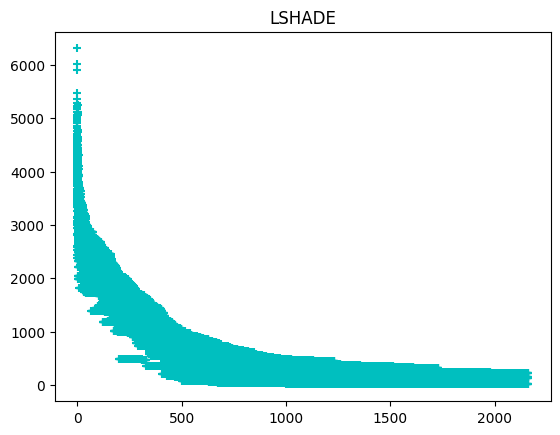

In [15]:
plot_scatter_cost_evolution(function, "lshade", dimension)

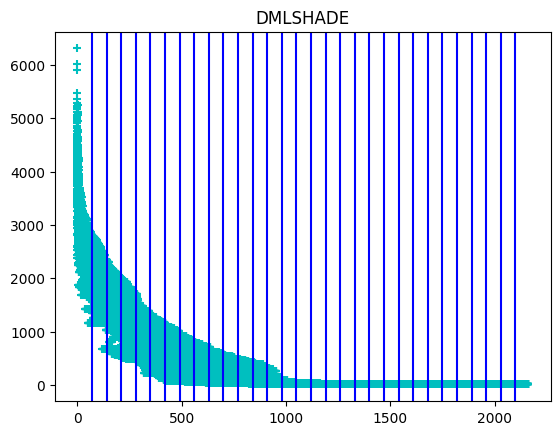

In [22]:
plot_scatter_cost_evolution(function, "dmlshade", dimension)

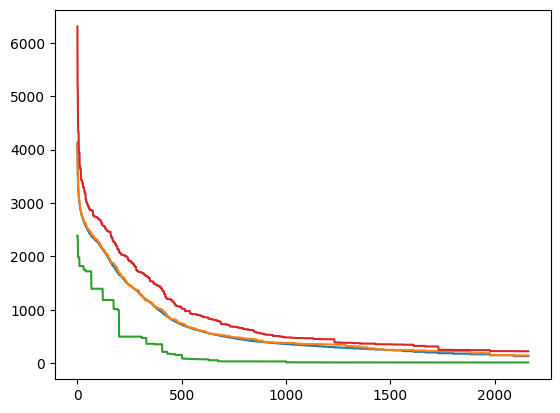

In [8]:
#plot_cost_evolution(function, "lshade")
plot_cost_statistics(function, "lshade", dimension)

2163
f11 finished


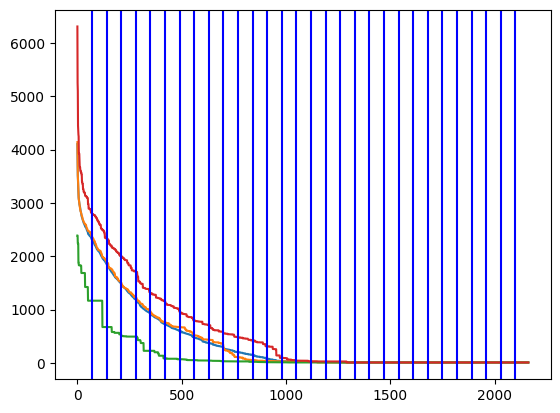

In [9]:
load_data(analyzer, "dmlshade", function, dimension)
#plot_cost_evolution(function, "dmlshade")
plot_cost_statistics(function, "dmlshade", dimension)

<Axes: >

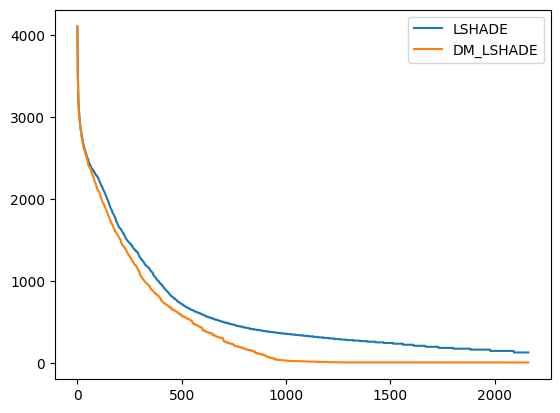

In [26]:
statistic = "mean"
lshade_costs = get_stat(function, "lshade", statistic, dimension)
dmlshade_costs = get_stat(function, "dmlshade", statistic, dimension)

lshade_costs.plot(legend=True, label="LSHADE")
dmlshade_costs.plot(legend=True, label="DM_LSHADE")

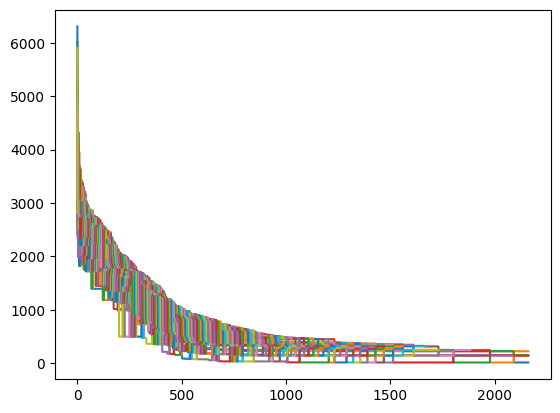

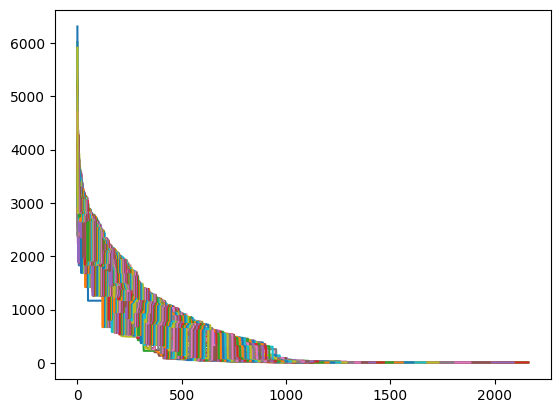

In [27]:
plot_cost_evolution(function, "lshade", dimension)
plot_cost_evolution(function, "dmlshade", dimension)